### Study on bias and interpretable models - SCHOOL PROJECT
*Nathan Lauga - December 2018*

*****

Hello world ! ✋



## Table of content

* 1. Load and prepare data
    * 1.1 Load libraries
    * 1.2 Load the data
    * 1.3 Quick EDA
    * 1.4 Work with feature
* 2. AIF360 Introduction
    * 2.1 Create dataset using aif360
    * 2.2 Quick look on the dataset
    * 2.3 First model
* 3. Bias and Fairness
    * 3.1 Metrics
    * 3.2 How to fix it ?
* 4. Interpretable model
    * 4.1 Feature importance
    * 4.2 LIME
    * 4.3 SHAP
* 5. Conclusion

## 1. Load and prepare data

### 1.1 Load libraries

In [11]:
%matplotlib inline
import pandas as pd
import numpy as np
from time import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches
plt.style.use('seaborn-white')
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import plotly.figure_factory as ff

# Custom visualisation functions in visualitions.py file
from visualisations import plot_fair_metrics

# Custom metrics functions in metrics.py file
from metrics import fair_metrics

from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

import lime
import lime.lime_tabular
import shap

from sklearn.preprocessing import Normalizer, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

from IPython.display import Markdown, display

### 1.2 Load the data

I choose to use the Adult dataset that you can find on the following link : [UCI Machine Learning Repository : Adult dataset](https://archive.ics.uci.edu/ml/datasets/adult)

In [12]:
cols = ["Age", "Workclass", "Final Weight", "Education", "Education-Num", "Marital Status","Occupation", "Relationship", "Race", "Sex", "Capital Gain", "Capital Loss","Hours per week", "Country", "Income"]
data = pd.read_csv('./data/adult.csv', header=None)
data.columns = cols

### 1.3 Quick EDA

In [13]:
data.head()

Age          Workclass  Final Weight   Education  Education-Num  \
0   39          State-gov         77516   Bachelors             13   
1   50   Self-emp-not-inc         83311   Bachelors             13   
2   38            Private        215646     HS-grad              9   
3   53            Private        234721        11th              7   
4   28            Private        338409   Bachelors             13   

        Marital Status          Occupation    Relationship    Race      Sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   Capital Gain  Capital Loss  Hours per week         Country  Income  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

Since Education-Num is the same as Education but classed by number we can drop it

In [14]:
data.drop(columns=['Education-Num'], inplace=True)

In [15]:
na_count = pd.DataFrame(data.apply(lambda x : x.isna()).sum()).transpose()
na_count

Age  Workclass  Final Weight  Education  Marital Status  Occupation  \
0    0          0             0          0               0           0   

   Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
0             0     0    0             0             0               0   

   Country  Income  
0        0       0

This dataset doesn't have any NA value so we don't have to work with that.

In [36]:
def plot_bar(data, column, color='#2980b9', orientation = 'h', type=None):
    data =  data[column].dropna().value_counts(ascending=True)

    x, y = (data.values, data.index) if orientation == 'h' else (data.index, data.values)
    trace = go.Bar(x=x, y=y, marker=dict(color=color)
           , opacity=0.9, orientation = orientation)
    layout = go.Layout(barmode='group', title='Bar plot for the '+column+' column', xaxis=dict(type=type))
    fig = go.Figure([trace], layout=layout)
    py.iplot(fig)
    
def plot_histo(data, column, type=None):
    trace = go.Histogram(x=data[column].dropna())
    layout = go.Layout(title='Histogram of the '+column+' column'
                       , yaxis= dict(type=type,autorange=True))
    fig = go.Figure([trace], layout=layout)
    py.iplot(fig)

#### Continuous columns

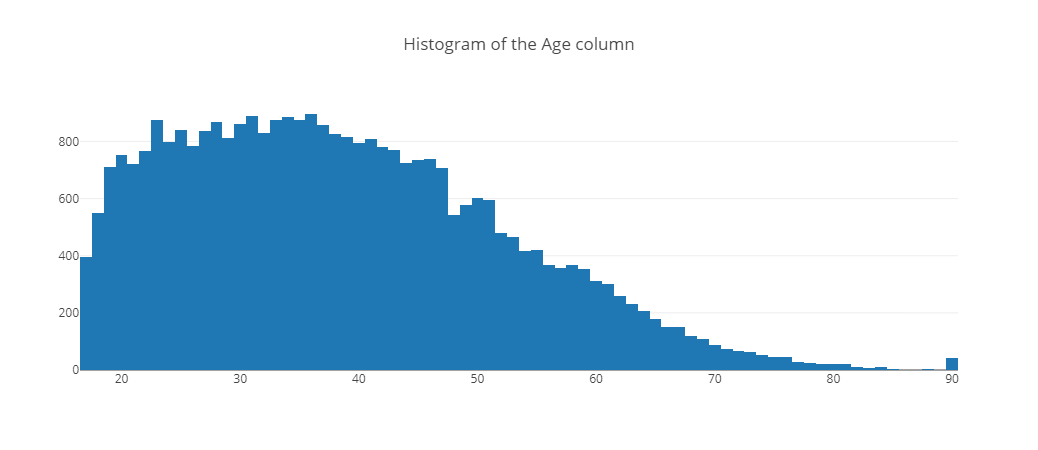

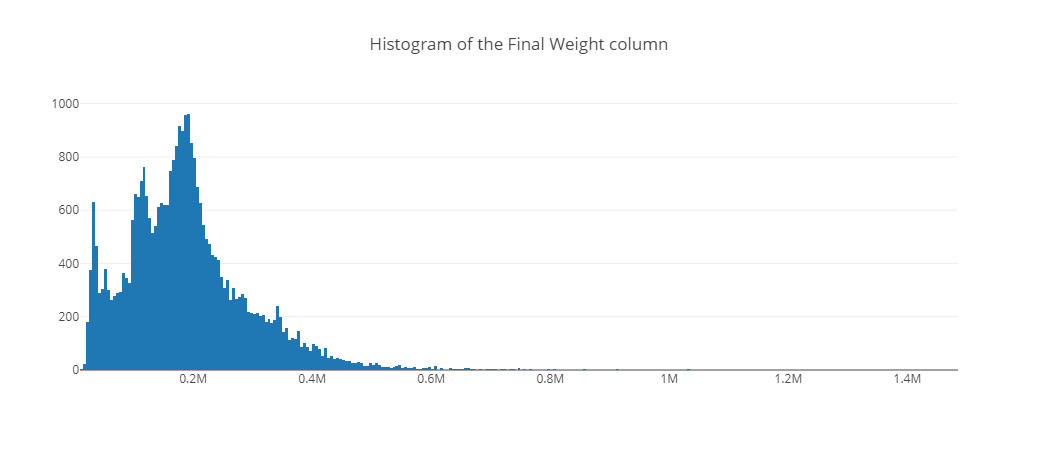

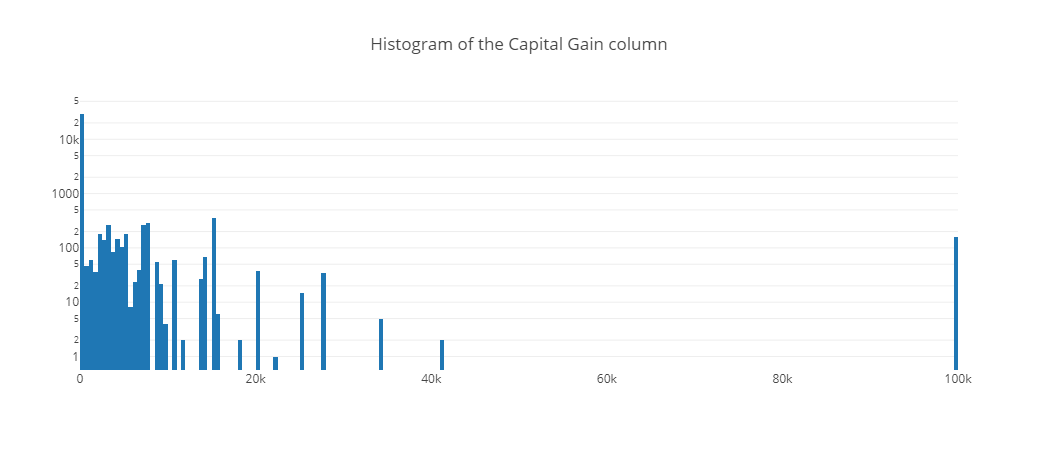

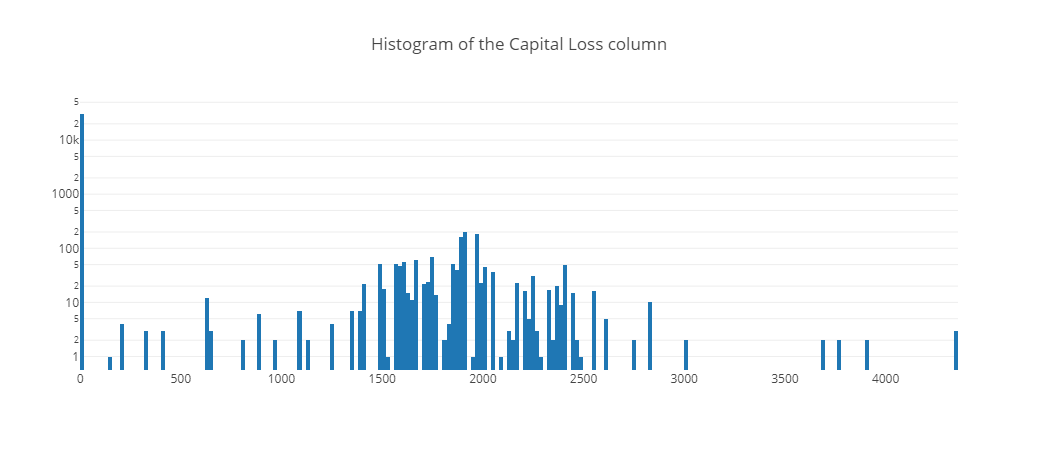

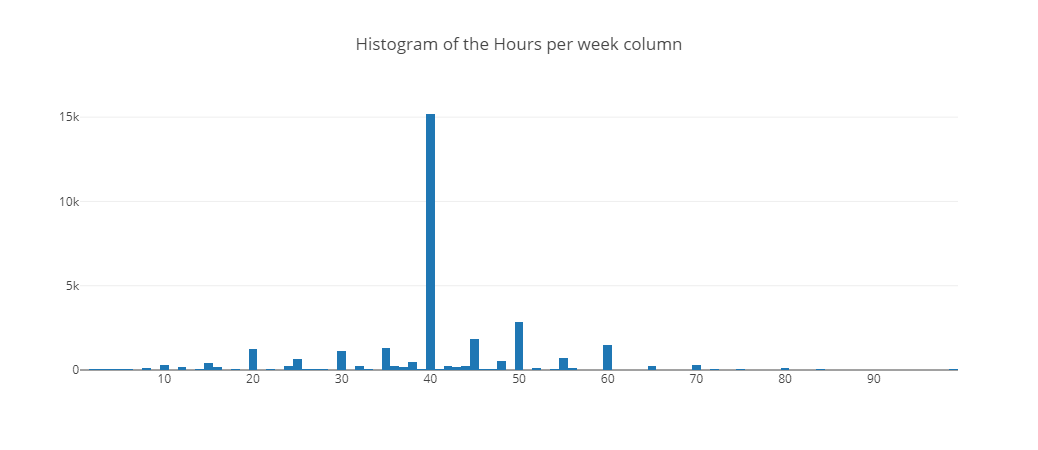

In [48]:
# print(data.columns.values)
display(Markdown('#### Continuous columns'))
plot_histo(data, 'Age')
plot_histo(data, 'Final Weight')
plot_histo(data, 'Capital Gain', type='log')
plot_histo(data, 'Capital Loss', type='log')
plot_histo(data, 'Hours per week')

#### Categorical columns

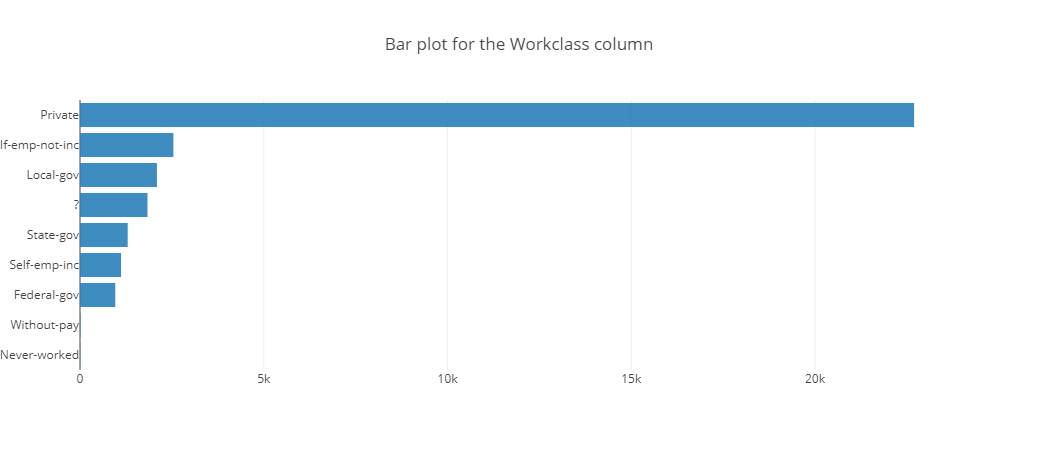

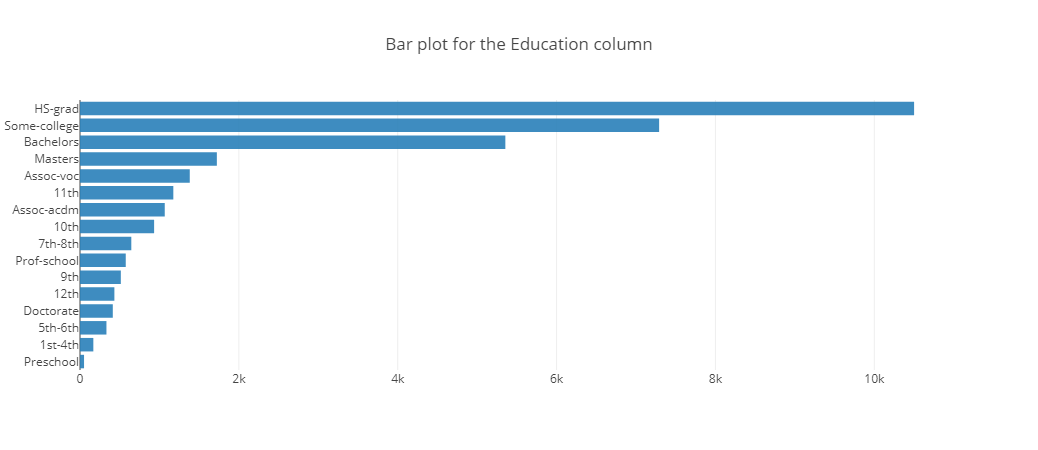

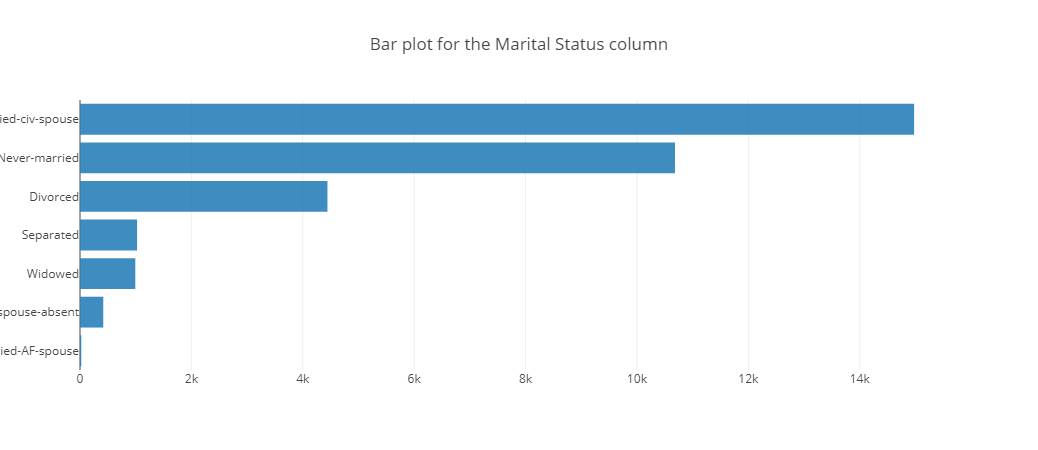

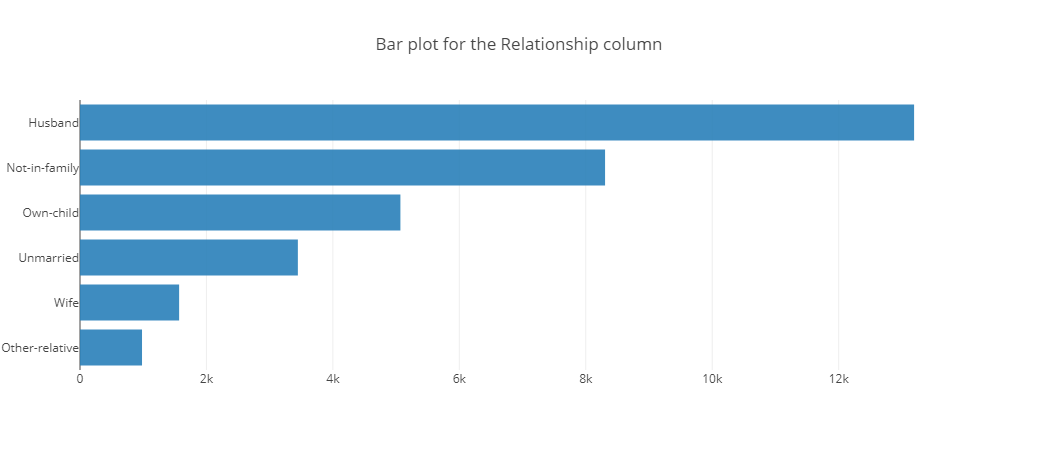

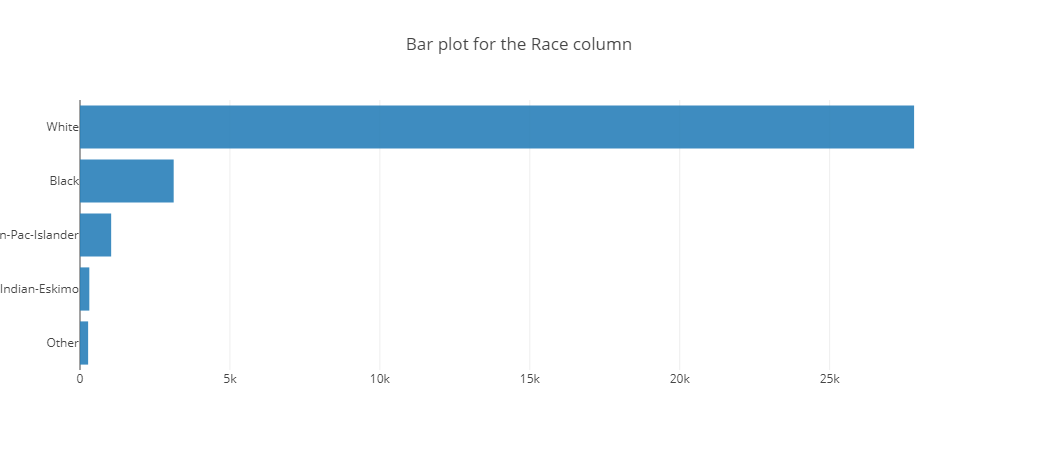

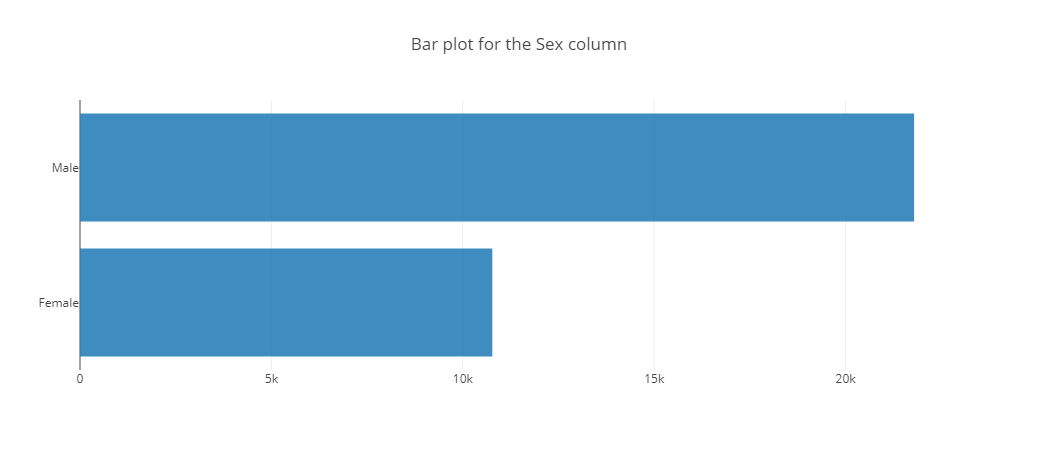

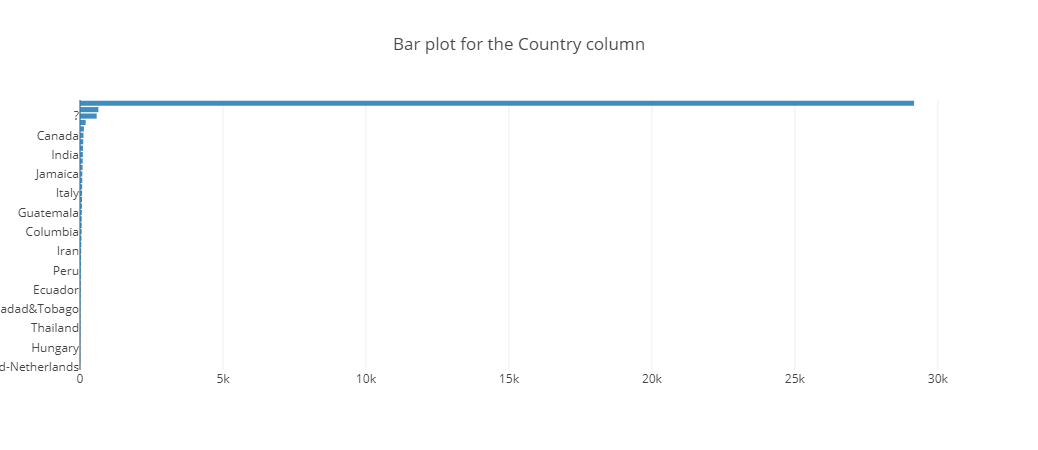

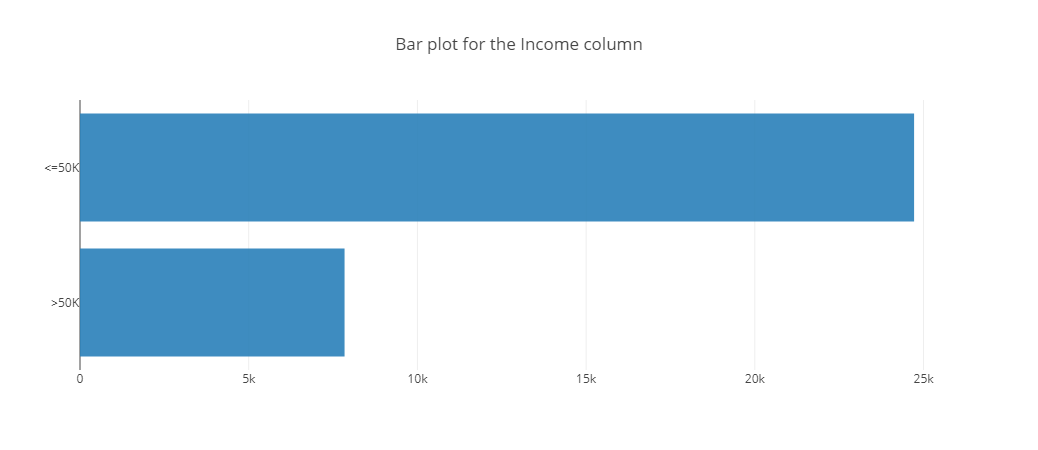

In [47]:
display(Markdown('#### Categorical columns'))
plot_bar(data, 'Workclass')
plot_bar(data, 'Education')
plot_bar(data, 'Marital Status')
plot_bar(data, 'Relationship')
plot_bar(data, 'Race')
plot_bar(data, 'Sex')
plot_bar(data, 'Country')
plot_bar(data, 'Income')

### 1.4 Work with feature

#### Encoding categorical columns

In [17]:
categorical_features = ["Workclass", "Education", "Marital Status","Occupation", "Relationship", "Race", "Sex", "Country", "Income"]
categorical_features_idx = [np.where(data.columns.values == col)[0][0] for col in categorical_features]

In [18]:
data_encoded = data.copy()

categorical_names = {}
encoders = {}

# Use Label Encoder for categorical columns (including target column)
for feature in categorical_features:
    le = LabelEncoder()
    le.fit(data_encoded[feature])
    
    data_encoded[feature] = le.transform(data_encoded[feature])
    
    categorical_names[feature] = le.classes_
    encoders[feature] = le
    
data_encoded = data_encoded.astype(float)

In [19]:
data_encoded.head()

Age  Workclass  Final Weight  Education  Marital Status  Occupation  \
0  39.0        7.0       77516.0        9.0             4.0         1.0   
1  50.0        6.0       83311.0        9.0             2.0         4.0   
2  38.0        4.0      215646.0       11.0             0.0         6.0   
3  53.0        4.0      234721.0        1.0             2.0         6.0   
4  28.0        4.0      338409.0        9.0             2.0        10.0   

   Relationship  Race  Sex  Capital Gain  Capital Loss  Hours per week  \
0           1.0   4.0  1.0        2174.0           0.0            40.0   
1           0.0   4.0  1.0           0.0           0.0            13.0   
2           1.0   4.0  1.0           0.0           0.0            40.0   
3           0.0   2.0  1.0           0.0           0.0            40.0   
4           5.0   2.0  0.0           0.0           0.0            40.0   

   Country  Income  
0     39.0     0.0  
1     39.0     0.0  
2     39.0     0.0  
3     39.0     0.0  
4      5.0     0.0

## 2. AIF360 Introduction
### 2.1 Create dataset using aif360

In [20]:
privileged_sex = np.where(categorical_names['Sex'] == ' Male')[0]
privileged_race = np.where(categorical_names['Race'] == ' White')[0]

In [21]:
data_orig = StandardDataset(data_encoded, 
                           label_name='Income', 
                           favorable_classes=[1], 
                           protected_attribute_names=['Sex', 'Race'], 
                           privileged_classes=[privileged_sex, privileged_race])

### 2.2 Quick look on the dataset

In [22]:
# print out some labels, names, etc.
display(Markdown("#### Dataset shape"))
print(data_orig.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(data_orig.favorable_label, data_orig.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(data_orig.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(data_orig.privileged_protected_attributes, data_orig.unprivileged_protected_attributes)
display(Markdown("#### Dataset feature names"))
print(data_orig.feature_names)

#### Dataset shape

(32561, 13)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['Sex', 'Race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([4.])] [array([0.]), array([0., 1., 2., 3.])]


#### Dataset feature names

['Age', 'Final Weight', 'Sex', 'Education', 'Marital Status', 'Workclass', 'Race', 'Country', 'Capital Loss', 'Hours per week', 'Capital Gain', 'Occupation', 'Relationship']


### 2.3 First model

#### Split into train and test set

In [23]:
np.random.seed(42)

data_orig_train, data_orig_test = data_orig.split([0.7], shuffle=True)

display(Markdown("#### Train Dataset shape"))
print(data_orig_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print(data_orig_test.features.shape)

#### Train Dataset shape

(22792, 13)


#### Test Dataset shape

(9769, 13)


#### Training the model : classic Random Forest 

In [24]:
def train_model(model, dataset):
    X_train = dataset.features
    y_train = dataset.labels.ravel()
    
    # Train the model
    model.fit(X_train, y_train, sample_weight=dataset.instance_weights)
    
    return model

# Model to learn
rf = RandomForestClassifier(n_estimators=100)

# Train and save the model
rf_orig = train_model(rf, data_orig_train)

#### Predict on test set

In [25]:
X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()
prediction_orig = rf_orig.predict(data_orig_test.features)

Now we have a model (Random forest) that is trained with the training dataset and the prediction of the test set. So in a first place let's check the performance of our model (accuracy, F1 Score, confusion matrix, ...).

#### Performance of the model

In [26]:
# TODO add visualisation and ROC curbes
def model_performance(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    matrix = confusion_matrix(y_true, y_pred)
    f1 = f1_score(y_true, y_pred) 
    print(accuracy)
    print(matrix)
    print(f1)
    
model_performance(prediction_orig, y_test)

0.8593510082915344
[[6941  923]
 [ 451 1454]]
0.6791219056515646


## 3. Bias and Fairness

Today, a problem of the model that can be produce by Machine Learning is bias that data can have. So a question is how to measure those bias and how to avoid them. In python there is a package produced by IBM called [aif360](https://aif360.readthedocs.io/en/latest/) that can gives us some metrics and algorithms to know if our data / model are bias and to get a fair model.

### 3.1 Metrics

So with aif360 we have some metrics that indicate if our data or model are bias. I will use 5 metrics : 
* Statistical Parity Difference
* Equal Opportunity Difference
* Average Absolute Odds Difference
* Disparate Impact
* Theil Index

#### Statistical Parity Difference

This measure is based on the following formula : 

$$ Pr(Y=1|D=unprivileged) - Pr(Y=1|D=privileged) $$

Here the bias or *statistical imparity* is the difference between the probability that a random individual drawn from unprivileged is labeled 1 (so here that he has more than 50K for income) and the probability that a random individual from privileged is labeled 1.

So it has to be close to **0** so it will be fair.

Also you can find more details about that here : [One definition of algorithmic fairness: statistical parity](https://jeremykun.com/2015/10/19/one-definition-of-algorithmic-fairness-statistical-parity/)


#### Equal Opportunity Difference

This metric is just a difference between the true positive rate of unprivileged group and the true positive rate of privileged group so it follows this formula :

$$ TPR_{D=unprivileged} - TPR_{D=privileged} $$ 

Same as the previous metric we need it to be close to **0**.

#### Average Absolute Odds Difference

This measure is using both false positive rate and true positive rate to calculate the bias. It's calculating the equality of odds with the next formula :

$$ \frac{1}{2}[|FPR_{D=unprivileged} - FPR_{D=privileged} | + | TPR_{D=unprivileged} - TPR_{D=privileged}|]$$

It needs to be equal to **0** to be fair.

#### Disparate Impact

For this metric we use the following formula :

$$ \frac{Pr(Y=1|D=unprivileged)}{Pr(Y=1|D=privileged)} $$

Like the first metric we use both probabities of a random individual drawn from unprivileged or privileged with a label of 1 but here it's a ratio. 

It changes the objective, for the disparate impact it's **1** that we need.

#### Theil Index

This measure is also known as the generalized entropy index but with $\alpha$ equals to 1 (more informations on [the Wikipedia page](https://en.wikipedia.org/wiki/Generalized_entropy_index)). So we can calculate it with this formula :

$$ \frac{1}{n} \sum_{i=0}^{n} \frac{b_i}{\mu} ln \frac{b_i}{\mu} $$ 

Where $b_i = \hat{y}_i - y_i + 1 $

So it needs to be close to **0** to be fair.


With these differents metrics we can see that for some we need the prediction and for others just the original dataset. This is why we will use 2 classes of the aif360 package : `ClassificationMetric` and `BinaryLabelDatasetMetric`. 

For the first one we need the prediction so we can have the following metrics : 
* Equal Opportunity Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.equal_opportunity_difference)
   
`equal_opportunity_difference()`
* Average Absolute Odds Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.average_abs_odds_difference)

`average_abs_odds_difference()`
* Theil Index : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.theil_index)

`theil_index()`

Then for the metrics that don't require prediction (the second class) we can use them with the following functions : 
* Statistical Parity Difference : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.BinaryLabelDatasetMetric.statistical_parity_difference)

`statistical_parity_difference()`
* Disparate Impact : [documentation link](https://aif360.readthedocs.io/en/latest/modules/metrics.html#aif360.metrics.ClassificationMetric.disparate_impact)

`disparate_impact()`


Now I construct a `DataFrame` that will keep the values of the differents metrics I talked just above with a function. 

In [27]:
# fair_metrics function available in the metrics.py file
fair = fair_metrics(data_orig_test, prediction_orig)

### Check bias metrics :

A model can be considered bias if just one of these five metrics show that this model is biased.

#### For the Sex attribute :

With default thresholds, bias against unprivileged group detected in **3** out of 5 metrics

#### For the Race attribute :

With default thresholds, bias against unprivileged group detected in **4** out of 5 metrics

statistical_parity_difference  equal_opportunity_difference  \
objective                       0.000000                      0.000000   
Sex                            -0.179308                     -0.110568   
Race                           -0.148526                     -0.393626   

           average_abs_odds_difference  disparate_impact  theil_index  
objective                     0.000000          1.000000     0.000000  
Sex                           0.091354          0.295175     0.116772  
Race                          0.209958          0.293590     0.116772

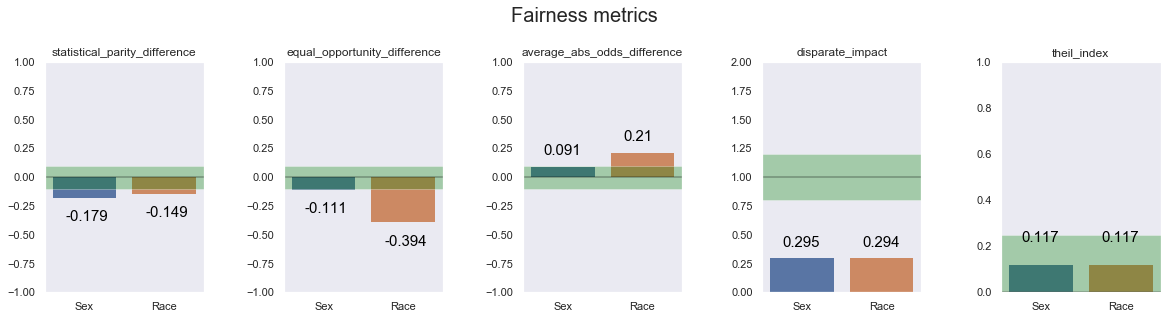

In [28]:
# plot_fair_metrics function available in the visualisations.py file
plot_fair_metrics(fair)
fair

As we can see, this first model is biased. The next step is to answer the question : How to fix it ?

### 3.2 How to fix it ?

## 4. Interpretable model
### 4.1 Feature importance

In [29]:
rf.feature_importances_
feature_imp = pd.Series(rf.feature_importances_, index=data_orig_train.feature_names)
feature_imp.sort_values(ascending=False, inplace=True)

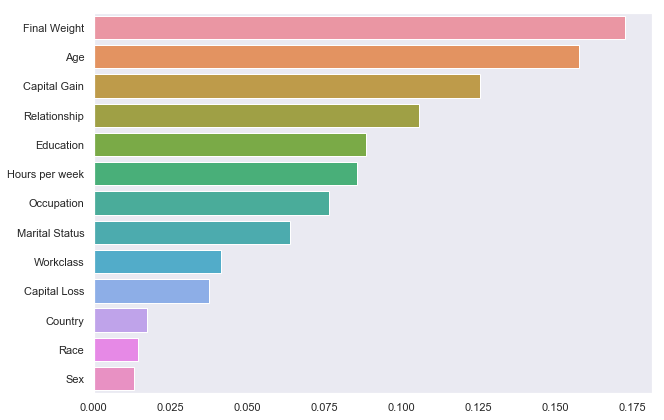

In [30]:
plt.figure(figsize=(10,7))
ax = sns.barplot(y=feature_imp.index.values, x=feature_imp,orient='h')

### 4.2 LIME

In [31]:
test_interp = pd.DataFrame(data=data_orig_test.features,
                            columns=data_orig_test.feature_names)

categorical_features = ["Workclass", "Education", "Marital Status","Occupation", "Relationship", "Race", "Sex", "Country"]
categorical_features_idx = [np.where(test_interp.columns.values == col)[0][0] for col in categorical_features]
categorical_names_LIME = {}

for feature, idx in zip(categorical_features, categorical_features_idx):
    categorical_names_LIME[idx] = categorical_names[feature]

explainer = lime.lime_tabular.LimeTabularExplainer(test_interp.values,
                                                   feature_names=test_interp.columns.values,
                                                   class_names=['Income <= 50K', 'Income > 50K'],
                                                   categorical_features=categorical_features_idx, 
                                                   categorical_names=categorical_names_LIME)

row = pd.DataFrame(data=[test_interp.iloc[1,:]], columns=test_interp.columns.values)
display(row)

exp = explainer.explain_instance(row.values[0], rf.predict_proba, num_features=7)
exp.show_in_notebook(show_table=True, show_all=False)

Age  Final Weight  Sex  Education  Marital Status  Workclass  Race  \
1  24.0      166036.0  1.0       15.0             2.0        6.0   4.0   

   Country  Capital Loss  Hours per week  Capital Gain  Occupation  \
1     39.0           0.0            60.0           0.0        14.0   

   Relationship  
1           0.0

### 4.3 SHAP

In [32]:
t0 = time()
print('start : %0.4f'%((time() - t0)))

# Create object that can calculate shap values
explainer = shap.TreeExplainer(rf)
print('explainer end : %0.4f'%((time() - t0)))

# Calculate Shap values
test = test_interp.iloc[0:10,:]
shap_values = explainer.shap_values(test)
print('shap values end : %0.4f'%((time() - t0)))

start : 0.0000
explainer end : 0.0828
shap values end : 5.2901


In [35]:
def plot_shap_explain(data, idx, model, explainer, shap_values, categorical_features=None, encoders=None):
    row = data.iloc[idx,:] 
    
    proba = model.predict_proba([row])[0]
    display(Markdown("Probability of having an Income <= 50K : **%0.2f**"%proba[0]))
    display(Markdown("Probability of having an Income > 50K : **%0.2f**"%proba[1]))
    
    if categorical_features != None:
        for feature in categorical_features:
            row[feature] = encoders[feature].inverse_transform([int(row[feature])])[0]
    
    shap.initjs()
    display(Markdown("#### Explaination based on the 0 label (Income <= 50K)"))
    display(shap.force_plot(explainer.expected_value[0], shap_values[0][idx,:], row))
    display(Markdown("#### Explaination based on the 1 label (Income > 50K)"))
    display(shap.force_plot(explainer.expected_value[1], shap_values[1][idx,:], row))

# shap.summary_plot(shap_values, test)
plot_shap_explain(test_interp, 1, rf, explainer, shap_values, categorical_features, encoders)

Probability of having an Income <= 50K : **0.69**

Probability of having an Income > 50K : **0.31**

#### Explaination based on the 0 label (Income <= 50K)

#### Explaination based on the 1 label (Income > 50K)

## 5. Conclusion